# Brain Tumor Classification and Segmentation

CU Boulder MSDS 

DTSA 5511 Final Project

# 1. Introduction

Imagine if you could take a picture of a spot that has recently appeared on your skin and have an app tell you whether or not you should actually be worried about it. While they shouldn't aim to replace doctors or dispense medical advice, large scale deep learning models have the potential to bring efficient and affordable medical care to billions of people around the world. 

The purpose of this project is to create a deep learning model capable of classifying and potentially segmenting (that is, drawing an area around) brain tumors from MRI scan images. This sort of classification project could assist doctors in diagnoses & automate tumor measurements with potentially life-saving impacts. 

## 1.1 The Dataset

The repository contains a curated/enhanced version of brain MRI scan images derived from two publicly available datasets. It is suitable for both classification and segmentation, including tumor type detection. The original datasets (and their enhancements) are noted as follows:

### Kaggle Brain Tumor MRI Dataset [5]
This dataset contains 3D MRI scans categorized into four classes:
* No tumor
* Glioma tumor
* Meningioma tumor
* Pituitary tumor

### SciDB Brain Tumor Dataset [6]
This dataset contains pixel-level annotated MRI slices with tumor segmentation masks for various types of tumors. 

These datasets were "enhanced" with image preprocessing including normalization of the pixel intensity and noise reduction. Each entry in the dataset consists of an MRI image, a segmentation mask, and a classification label. There are approximately **5,000** images total.

## 1.2 Plan of Action

I will tackle the classification problem for this project, first using a 'basic' CNN with hyperparameter tuning and then using ResNet50, a 50-layer Residual Neural Network (RNN) that is often used for image classification. ResNet50 was trained on the ImageNet dataset, so it will be interesting to see how it compares to the CNN.

In [1]:
# Import the necessary classes!

# Basics
import numpy as np
import pandas as pd
import os, random, PIL, warnings

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Tensorflow/Keras
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50

# SKLearn
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split


2025-06-22 01:53:06.360512: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750557186.536164      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750557186.586056      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
warnings.filterwarnings('ignore')

# Set a seed for reproducability.
tf.random.set_seed(47)
np.random.seed(47)

# 2. Dealing with the Data
In this section, I'll load and preprocess the dataset and perform some exploratory data analysis (EDA) so we can better understand the data.

## 2.1 Loading the Data

In [3]:
homeDir = '/kaggle/input/brain-tumor-dataset-segmentation-and-classification/DATASET'
trainDir = os.path.join(homeDir,'classification','Training')
testDir = os.path.join(homeDir,'classification','Testing')

classes = ['notumor','glioma','meningioma','pituitary'] # labels 0,1,2,3

In [4]:
# Function to create a basic dataframe for the image files containing the image path
# and the class label for that image.
def makeDF(dir, classes):
    frame = {
        'filepath': [],
        'label': [],
        'imgsize': []
    }
    for c in classes:
        classDir = os.path.join(dir,c)
        for file in os.listdir(classDir):
            fileDir = os.path.join(classDir,file)

            frame['filepath'].append(fileDir)
            frame['label'].append(c)

            img = PIL.Image.open(fileDir)
            frame['imgsize'].append((img.width,img.height))


    df = pd.DataFrame(frame)
    df = df.sample(frac=1)
    df.reset_index(inplace=True)
    return df

## 2.2 Exploratory Data Analysis

In [5]:
trainDF = makeDF(trainDir,classes)
testDF = makeDF(testDir,classes)

print(f'There are {len(trainDF)} training images.')
print(f'There are {len(testDF)} testing images.')

There are 5712 training images.
There are 1311 testing images.


In [6]:
print(f'There are {trainDF.isna().sum().sum()} missing training images.')
print(f'There are {trainDF.duplicated().sum().sum()} duplicated training images.')

print(f'\nThere are {testDF.isna().sum().sum()} missing testing images.')
print(f'There are {testDF.duplicated().sum().sum()} duplicated testing images.')

There are 0 missing training images.
There are 0 duplicated training images.

There are 0 missing testing images.
There are 0 duplicated testing images.


In [7]:
# Here's a quick shot of what the training dataframe looks like.
trainDF.sample(5)

,index,filepath,label,imgsize
4041,4573,/kaggle/input/brain-tumor-dataset-segmentation...,pituitary,"(512, 512)"
4194,3129,/kaggle/input/brain-tumor-dataset-segmentation...,meningioma,"(512, 512)"
5148,5010,/kaggle/input/brain-tumor-dataset-segmentation...,pituitary,"(512, 512)"
5450,2029,/kaggle/input/brain-tumor-dataset-segmentation...,glioma,"(512, 512)"
3782,840,/kaggle/input/brain-tumor-dataset-segmentation...,notumor,"(225, 225)"


In [8]:
# Okay, so it looks like there are a bunch of differently-sized images. Cool.
imgSizes = trainDF.imgsize.tolist()
print(f'There are {len(set(imgSizes))} unique image sizes.')
print('\nExample image sizes:')
print(set(imgSizes[:10]))

# We're definitely going to need to resize these so they're all the same.

There are 382 unique image sizes.

Example image sizes:
{(468, 444), (512, 512), (630, 630)}


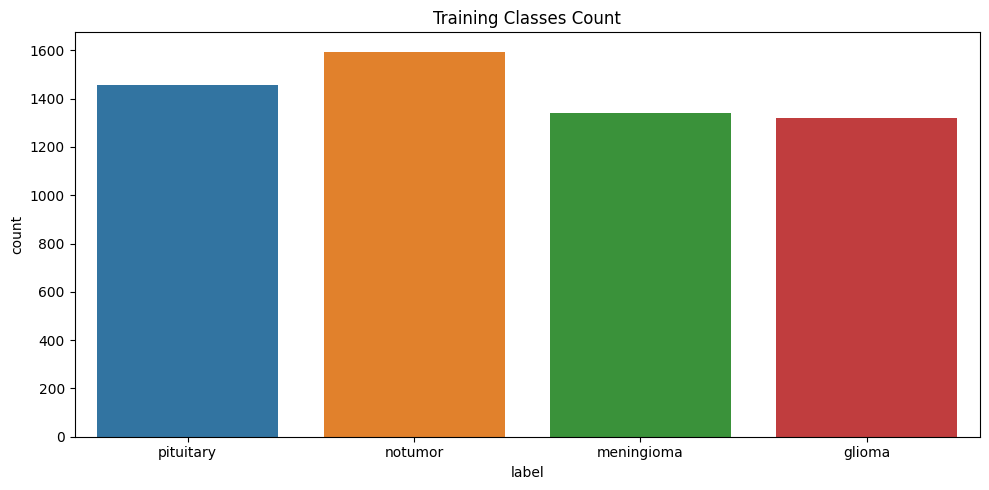

In [9]:
# Let's see the class breakdown.
plt.figure(figsize=(10,5))
sns.countplot(x=trainDF.label)
plt.title('Training Classes Count')
plt.tight_layout()
plt.show()

I0000 00:00:1750557234.395590      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


<Figure size 800x800 with 0 Axes>

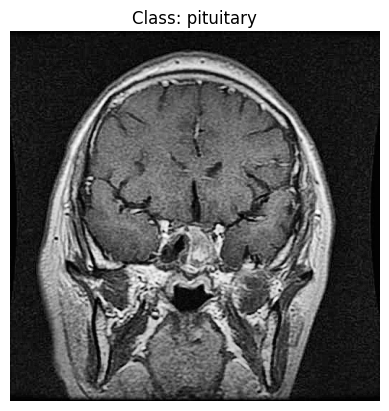

Image size: (512, 512)


In [10]:
# Now let's look at a sample image.
imgDF = trainDF.sample(1)
imgPath = imgDF.filepath.tolist()[0]

img = tf.io.read_file(imgPath)
img = tf.image.decode_jpeg(img,channels=3)
img = img.numpy()

plt.figure(figsize=(8,8))
fig,ax = plt.subplots(1)
ax.imshow(img)
ax.grid(False)
ax.set_title(f'Class: {imgDF.label.values[0]}')
plt.axis('off')
plt.show()

imgDet = PIL.Image.open(imgPath)
print(f'Image size: {imgDet.width, imgDet.height}')

In [11]:
# One more thing: let's one-hot encode the categories here 
# to make life easier down the road.
trainDF = pd.concat([trainDF,pd.get_dummies(trainDF.label).astype(int)[classes]],axis=1)
testDF = pd.concat([testDF,pd.get_dummies(testDF.label).astype(int)[classes]],axis=1)

trainDF.sample(5)

,index,filepath,label,imgsize,notumor,glioma,meningioma,pituitary
3048,5606,/kaggle/input/brain-tumor-dataset-segmentation...,pituitary,"(512, 512)",0,0,0,1
2931,2183,/kaggle/input/brain-tumor-dataset-segmentation...,glioma,"(512, 512)",0,1,0,0
5218,1746,/kaggle/input/brain-tumor-dataset-segmentation...,glioma,"(512, 512)",0,1,0,0
1672,5533,/kaggle/input/brain-tumor-dataset-segmentation...,pituitary,"(512, 512)",0,0,0,1
4513,3102,/kaggle/input/brain-tumor-dataset-segmentation...,meningioma,"(512, 512)",0,0,1,0


## Exploratory Data Analysis Conclusions

We learned there are 5,712 training images of varying sizes in the training dataset, and 1,311 images (also varying sizes) in the testing dataset. The images are currently black and white to the naked eye, though technically they're in RGB (3 channels). I plotted them with one channel once and was treated to a very interesting heatmap-looking version of the same image. We're also very lucky that this dataset is really clean, with no missing or duplicated images in the train or test sets.

To preprocess the images, we definitely need to standardize their sizes for the model. Additionally, I'd like to apply some random rotations, flips, and contrast to the training images to prevent overfitting. 

## 2.3 Preprocessing the Images

One thing we also need to do here is split the original training dataset into "model train" and "model validation" datasets. I don't want to use the test dataset as the validation data when training the model.

In [12]:
# Some random image augments for training
def augmentImage(img):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    if tf.random.uniform([]) > 0.5:
        img = tf.image.rot90(img,k=tf.random.uniform([],minval=1,maxval=4,dtype=tf.int32))
        img = tf.image.random_brightness(img,max_delta=0.2)
        img = tf.image.random_contrast(img,lower=0.8,upper=1.2)

    return img

# Load and preprocess (resize) image
def loadPreprocessImage(path,label,training=True):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img,channels=3)
    img = tf.cast(img,tf.float32)/255.0
    if training:
        img = augmentImage(img)

    img = tf.image.resize(img,[128, 128])
    return img, label

In [13]:
# Training data
trainPaths = trainDF.filepath.to_list()
trainLabels = trainDF[classes].values

# Split into train and validation data
xTrain, xTest, yTrain, yTest = train_test_split(trainPaths,trainLabels,test_size=0.2,random_state=47)

# Get testing data
testPaths = testDF.filepath.to_list()
testLabels = testDF[classes].values

In [14]:
# Get training dataset
trainDS = tf.data.Dataset.from_tensor_slices((xTrain,yTrain))
trainDS = trainDS.map(
    lambda x,y: loadPreprocessImage(x,y,training=True),
    num_parallel_calls = tf.data.AUTOTUNE
)
trainDS = trainDS.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.AUTOTUNE)

# Get validation dataset
valDS = tf.data.Dataset.from_tensor_slices((xTest,yTest))
valDS = valDS.map(
    lambda x,y: loadPreprocessImage(x,y,training=True),
    num_parallel_calls = tf.data.AUTOTUNE
)
valDS = valDS.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.AUTOTUNE)

# Get testing dataset
testDS = tf.data.Dataset.from_tensor_slices((testPaths,testLabels))
testDS = testDS.map(
    lambda x,y: loadPreprocessImage(x,y,training=False),
    num_parallel_calls=tf.data.AUTOTUNE
)
testDS = testDS.batch(32).prefetch(tf.data.AUTOTUNE)

# 3. The CNN Model

## 3.1 Definition & Hyperparameter Tuning

I'm building this model with 2 convolutional blocks and tuning the following hyperparameters:
* Number of filters in the second block (64,128)
* Number of dense units in the first dense layer (128,256)
* The learning rate in the optimizer

### Update! 
Initial training gave a validation accuracy of between 90-91%. I wanted to see if I could increase the accuracy, so I added a third convolutional block, between the 'UPDATE' comments below. After this addition, the validation accuracy increased to ~94%.

In [15]:
def createBase(hp):
    model = models.Sequential([
        # Convolutional Block 1
        layers.Input(shape=(128,128,3)),
        layers.Conv2D(filters=32,kernel_size=3,activation='relu'),
        layers.MaxPooling2D(),

        # Conv Block 2
        layers.Conv2D(hp.Int('conv_units',64,128,step=64),
                     kernel_size=3,
                     activation='relu'),
        layers.MaxPooling2D(),

        # Conv Block 3 ---- UPDATE -----
        layers.Conv2D(filters=128,kernel_size=3,activation='relu'),
        layers.MaxPooling2D(),
        # --- END UPDATE --- #
        
        # Flatten & Dense Layers
        layers.Flatten(),
        layers.Dense(hp.Int('dense_units',128,256,step=128),
                    activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(len(classes),activation='softmax')
    ])

    model.compile(
        optimizer=Adam(hp.Choice('learning_rate',[1e-4, 1e-3])),
        loss = 'categorical_crossentropy', 
        metrics = ['accuracy',tf.keras.metrics.AUC()]
    )

    return model

In [16]:
# Make the hyperparameter tuner
cnnTuner = kt.RandomSearch(
    createBase,
    objective='val_accuracy',
    directory='cnnTuning'
)

# Create callbacks
aintNoHollaBacks = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=2,
        restore_best_weights=True
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=4,
        min_lr=1e-6
    )    
]

cnnTuner.search(
    trainDS,
    validation_data=valDS,
    epochs=10,
    callbacks=aintNoHollaBacks
)

Trial 8 Complete [00h 02m 01s]
val_accuracy: 0.8932633399963379

Best val_accuracy So Far: 0.8950130939483643
Total elapsed time: 00h 16m 07s


In [17]:
# Now let's get the best model.
cnn_bestHyper = cnnTuner.get_best_hyperparameters(num_trials=1)[0]

print('Best Conv Units: ' + str(cnn_bestHyper.get('conv_units')))
print('Best Dense Units: ' + str(cnn_bestHyper.get('dense_units')))
print('Best Learning Rate: ' + str(cnn_bestHyper.get('learning_rate')))

Best Conv Units: 128
Best Dense Units: 256
Best Learning Rate: 0.001


In [18]:
cnnModel = createBase(cnn_bestHyper)

cnnModel.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 61, 61, 128)         │          36,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,609,284 (25.21 MB)

 Trainable params: 6,609,284 (25.21 MB)

 Non-trainable params: 0 (0.00 B)

## 3.2 Training

In [19]:
cnnHist = cnnModel.fit(x=trainDS,validation_data=valDS,epochs=25)

Epoch 1/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 85ms/step - accuracy: 0.4758 - auc_3: 0.7441 - loss: 1.1800 - val_accuracy: 0.6535 - val_auc_3: 0.9008 - val_loss: 0.7443
Epoch 2/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.7182 - auc_3: 0.9206 - loss: 0.6742 - val_accuracy: 0.6990 - val_auc_3: 0.9128 - val_loss: 0.7540
Epoch 3/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.7670 - auc_3: 0.9438 - loss: 0.5633 - val_accuracy: 0.8171 - val_auc_3: 0.9596 - val_loss: 0.4792
Epoch 4/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 0.8276 - auc_3: 0.9667 - loss: 0.4280 - val_accuracy: 0.8381 - val_auc_3: 0.9667 - val_loss: 0.4230
Epoch 5/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.8838 - auc_3: 0.9791 - loss: 0.3335 - val_accuracy: 0.8600 - val_auc_3: 0.9762 - val_loss: 0.3575
Epoch 6/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - accuracy: 0.9019 - auc_3: 0.9864 - loss: 0.2640 - val_accuracy: 0.8679 - val_auc_3: 0.9753 - val_loss: 0.3669
Epoc

## 3.3 Results

This is the fun part! Let's see how the model performed!

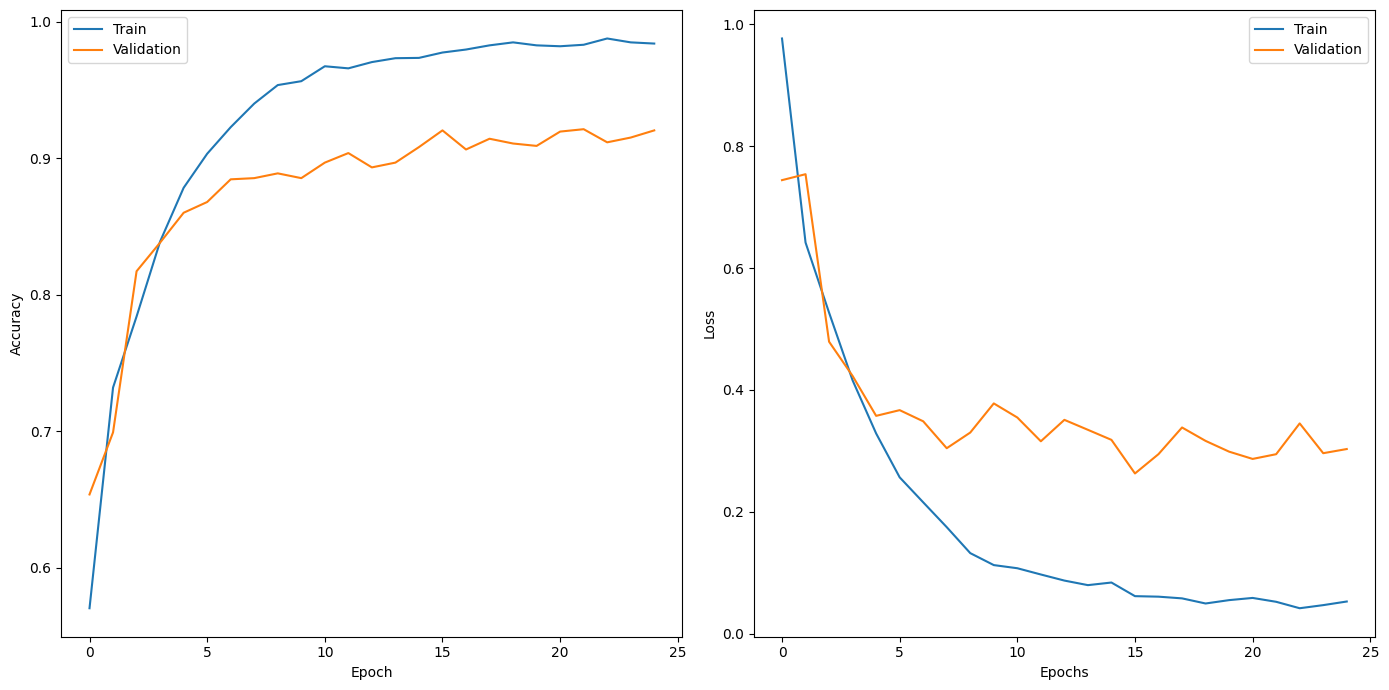

In [20]:
# Plot the training and validation accuracies
plt.figure(figsize=(14,7))

# Accuracy
plt.subplot(1,2,1)
plt.plot(cnnHist.history['accuracy'],label='Train')
plt.plot(cnnHist.history['val_accuracy'],label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(cnnHist.history['loss'],label='Train')
plt.plot(cnnHist.history['val_loss'],label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
# Make predictions!
yPredCN = cnnModel.predict(testDS)
yPredCN = np.argmax(yPredCN,axis=1)
yTrue = np.argmax(testLabels,axis=1)

print(f'Base CNN Accuracy: {accuracy_score(yTrue,yPredCN)*100:.2f}%')

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
Base CNN Accuracy: 92.14%


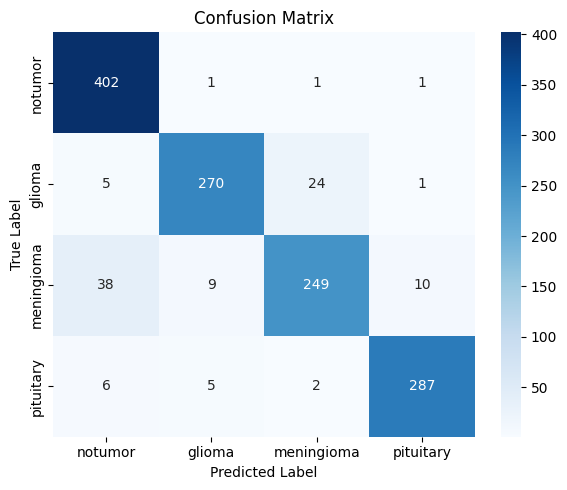

In [22]:
cm = confusion_matrix(yTrue,yPredCN)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=classes,
    yticklabels=classes
)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

## CNN Performance Conclusions

Overall, the model did pretty well with the input data, garnering a test accuracy score of 94%, with losses and accuracies that leveled out after about the 12-15th epoch. 

The confusion matrix shows that gliomas are most often confused for meningiomas. Gliomas arise from glial cells, which make up the supporting architecture of the brain and spinal cord (and are often malignant), while meningiomas arise from the meninges, which is the tissue that covers the brain and spinal cord. Since these tumors are most likely to occur in similar areas (the pituitary gland, in contrast, is in the center/base of the brain), it is understandable that the two might get confused.

# 4. The ResNet50 Model

## 4.1 Definition

Here we will instantiate a model with the same learning rate but the base layers will be the ResNet50 pretrained model with the ImageNet weights. We'll set this layer to not be trained and add two Dense output layers with the same activations as above. Additionally, I needed to add a Flatten() layer to get the output of the model to agree with the target.

### Update! 
After watching it train the first time, I could see this model wasn't as accurate as the first, so I decided to unfreeze the last 5 or so layers of the ResNet50 model to see if that would improve accuracy. The code between the 'UPDATE' comment blocks was added after this.

In [23]:
def createResNet():
    model = models.Sequential([
        ResNet50(include_top=False,weights='imagenet',input_shape=(128,128,3)),
        layers.Flatten(),
        layers.Dense(128,activation='relu'),
        layers.Dense(len(classes),activation='softmax')
    ])
    #--- UPDATE ---#
    for layer in model.layers[0].layers[:45]: # don't train all of ResNet50
        layer.trainable = False
    #--- END UPDATE ---#

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy',tf.keras.metrics.AUC()]
    )

    return model

In [24]:
resModel = createResNet()
resModel.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 4, 4, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       4,194,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,782,660 (105.98 MB)

 Trainable params: 27,321,732 (104.22 MB)

 Non-trainable params: 460,928 (1.76 MB)

## 4.2 Training

In [25]:
resHist = resModel.fit(
    trainDS,
    validation_data=valDS,
    epochs=10
)

Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 91s 248ms/step - accuracy: 0.5271 - auc_4: 0.7825 - loss: 2.5090 - val_accuracy: 0.2642 - val_auc_4: 0.5154 - val_loss: 5.0825
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - accuracy: 0.6641 - auc_4: 0.8968 - loss: 0.7862 - val_accuracy: 0.4392 - val_auc_4: 0.6840 - val_loss: 3.2786
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 14s 88ms/step - accuracy: 0.8235 - auc_4: 0.9592 - loss: 0.4800 - val_accuracy: 0.7218 - val_auc_4: 0.9182 - val_loss: 0.7344
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 14s 88ms/step - accuracy: 0.8637 - auc_4: 0.9761 - loss: 0.3631 - val_accuracy: 0.4969 - val_auc_4: 0.7090 - val_loss: 3.9753
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 88ms/step - accuracy: 0.8765 - auc_4: 0.9779 - loss: 0.3455 - val_accuracy: 0.3911 - val_auc_4: 0.6713 - val_loss: 2.7125
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - accuracy: 0.8995 - auc_4: 0.9846 - loss: 0.2846 - val_accuracy: 0.3972 - val_auc_4: 0.6395 - val_loss: 2.7999
Epo

## 4.3 Results

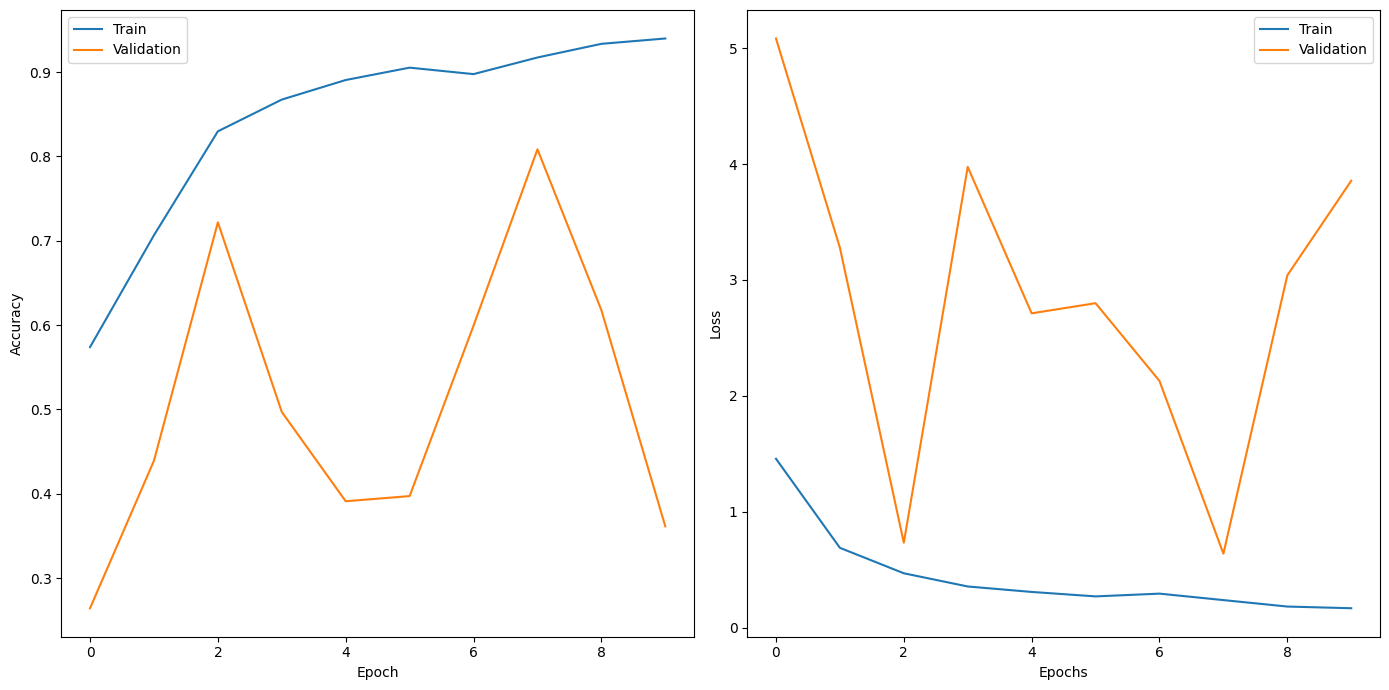

In [26]:
# Plot the training and validation accuracies
plt.figure(figsize=(14,7))

# Accuracy
plt.subplot(1,2,1)
plt.plot(resHist.history['accuracy'],label='Train')
plt.plot(resHist.history['val_accuracy'],label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(resHist.history['loss'],label='Train')
plt.plot(resHist.history['val_loss'],label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [27]:
# Make predictions!
yPredRS = resModel.predict(testDS)
yPredRS = np.argmax(yPredRS,axis=1)

print(f'ResNet50 Model Accuracy: {accuracy_score(yTrue,yPredRS)*100:.2f}%')

41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 165ms/step
ResNet50 Model Accuracy: 40.81%


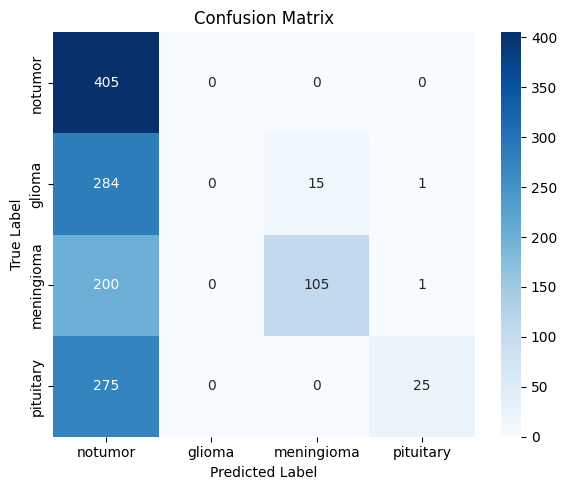

In [28]:
cm = confusion_matrix(yTrue,yPredRS)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=classes,
    yticklabels=classes
)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

## ResNet50 Model Performance Conclusions

This model had a surprisingly worse accuracy of only 70%, with accuracies peaking around the 3rd epoch. My guess is that the ResNet50 with the image weights had not been trained on anything like MRI scans before, so those weights weren't entirely applicable to the task at hand.

The model seemed to have the most issues recognizing meningiomas, as it confused them almost equally between pituitary and glioma tumors, sometimes even categorizing the images as not presenting a tumor at all.

# 5. Model Evaluation

The 'custom' CNN model proved to be the better choice for this task, returning a validation accuracy of 94%. The ResNet50 model's pretrained weights likely were not applicable to this task, so its more involved architecture did not do it any favors. Below we examine pictures categorized by the two models.

In [29]:
def visualizeResults(n):
    sampleDF = testDF.sample(n)
    imgPaths = sampleDF.filepath.tolist()

    for ii in range(n):
        img = tf.io.read_file(imgPaths[ii])
        img = tf.image.decode_jpeg(img,channels=3)
        img = img.numpy()

        trueClass = sampleDF.label.values[ii]
        (imgBatch,_) = loadPreprocessImage(imgPaths[ii],label=None,training=False)
        imgBatch = tf.expand_dims(imgBatch,axis=0)

        cnnProbs = cnnModel.predict(imgBatch)
        cnnClass = tf.argmax(cnnProbs[0]).numpy()

        resProbs = resModel.predict(imgBatch)
        resClass = tf.argmax(resProbs[0]).numpy()

        plt.figure(figsize=(8,8))
        fig,ax = plt.subplots(1)
        ax.imshow(img)
        ax.grid(False)
        ax.set_title(f'True Class: {trueClass} \nCNN Class: {classes[cnnClass]} \nResNet50 Class: {classes[resClass]}')
        plt.axis('off')
        plt.show()
        

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


<Figure size 800x800 with 0 Axes>

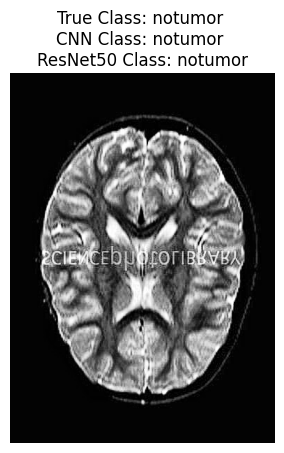

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


<Figure size 800x800 with 0 Axes>

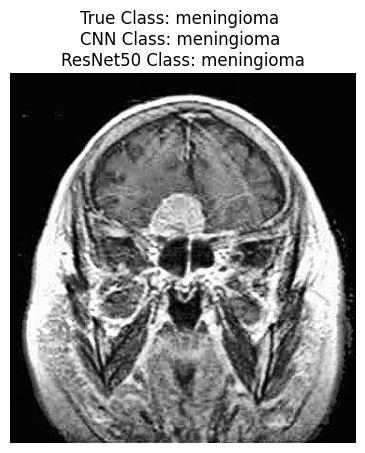

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


<Figure size 800x800 with 0 Axes>

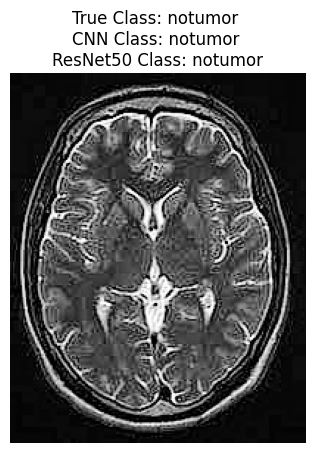

In [30]:
visualizeResults(3)

# 6. Conclusions

In this project, I developed two models to detect and classify brain tumors from MRI scan images. 

### 'Basic' CNN Model
This model had 2 convolutional blocks and was tuned to discover the best hyperparameters, which were as follows.
* Convolutional Block 2 Filters: 128
* Dense Layer 1 Units: 256
* Learning Rate: 0.001
  
This model returned a test accuracy of 94% after training for 20 epochs. The accuracies and losses settled at around 10-12 epochs, indicating a well-fit model. The confusion matrix showed the most commonly confused classes were glioma and meningioma, which is fairly understandable given the relatively similar locations of tumor origin.

### ResNet50 Model
This model used the ResNet50 model with ImageNet weights as a non-trainable base. ResNet50 is a deep model that has been pre-trained on a very large dataset of images and as such is commonly used for image classification tasks. This model had a test accuracy of only 70% and stopped itself early. The pretrained weights were likely not optimal for this task.

### Lessons Learned
Playing around with the data (not all of which is captured here) was probably the most informative portion of this project. I was able to learn some of the importance of the channels fed into the model. Originally, upon seeing the pictures were in black and white, I incorrectly assumed there was only one channel; while the CNN was able to handle training with this image shape, ResNet50 was not, which led to the investigation and subsequent discovery that one should not judge by appearances alone. And then I thought to myself, you're an idiot.

Preprocessing the images-- changing their shape, and the random flips, rotations, and contrasts applied to the training set-- is also important as it not only allows the models to work (in the case of image shape) but prevents overfitting by ensuring the model isn't biased toward specific orientations, etc. during training. This allows for better test accuracy.

I'd also never worked with a pretrained model base (like ResNet50) before, so it was very interesting to see how I was supposed to get that to work. Watching the first iteration of that model train was surprising-- the CNN model's accuracy shot up really quickly to over 80% in the first four epochs while the ResNet50 model was much slower. This led to the idea that I should attempt some sort of training of the ResNet50 model. Unfortunately, it didn't improve the accuracy of the model all that much. I'd like to investigate that further.

### Future Work
There is an entire other task attached to this dataset-- segmentation! I'd be curious to see whether the CNN model I devised for classification would have any luck at this task (though I rather doubt it). Perhaps the other way around, though-- some model I develop for segmentation could perhaps derive tumor classification from their position and/or size? 

Additionally, I'd like to better understand the ResNet50 and why it didn't work for this particular application, as I saw other versions of it and similar pretrained models work for other people using this dataset.

# References

These notebooks helped me get started: 

[1] https://www.kaggle.com/code/a3amat02/brain-tumor-classification-using-resnet50

[2] https://www.kaggle.com/code/carlosazb/tensorflow-keras-cnn-class-and-segmentation

[3] https://www.kaggle.com/code/ibrahimnibrahim/mri-tumor-classification-f1-0-993-on-test

This is the dataset used: 

[4] Indrakumar K, and Ravikumar M. (2025). Brain Tumor Dataset: Segmentation & Classification [Data set]. Kaggle. https://doi.org/10.34740/KAGGLE/DSV/11957028  

[5] Masoud Nickparvar, Kaggle Brain Tumor Dataset, 2020. https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset

[6] SciDB Brain Tumor Dataset, SciDB, 2021. https://www.scidb.cn/en/detail?dataSetId=faa44e0a12da4c11aeee91cc3c8ac11e